In [ ]:
import os
import re
import numpy as np
import cv2
from tqdm import tqdm
import scipy.io as sio
import matplotlib.pyplot as plt
import time
import pandas as pd

# Comment this if running locally

In [ ]:
from google.colab import drive#comment this out if you are using local
drive.mount('/content/drive')# same

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Data(Change the Directory!!!)

In [ ]:
frame_rate = 28 # change to 28
directory_path='/content/drive/My Drive/project/stimuli_image_png/'
target_height, target_width = 128,128
resize_x,resize_y= 250,280 #you can set to 0 here to see the effect of not cropping

In [ ]:
def sort_trials(name):
    return int(re.search(r'\d+', name).group())

In [ ]:
def process_data(directory_path,frame_rate,target_height,target_width,resize_x,resize_y):

    all_trials = [f for f in os.listdir(directory_path)]

    sorted_trials = sorted(all_trials, key=sort_trials)

    trial_num= len(sorted_trials)#record trial number

    combined_array = np.empty((trial_num,target_height,target_width, frame_rate))

    start_time = time.time()# start time

    for trial in sorted_trials:
        #find individual trial name
        trial_index = int(re.search(r'\d+$', trial).group())

        for frame in tqdm(range(frame_rate), desc=f'Processing {trial}', leave=False,position=0):
            file_path = f'{directory_path}/{trial}/frame_{frame+1}.png'
            image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

            #crop the image
            image=image[resize_y+50:1080-resize_y,resize_x:(1920-resize_x)]

            image = np.concatenate((image[:, :300], image[:, 620:]), axis=1)
            image = np.concatenate((image[:, :500], image[:, 820:]), axis=1)

            #resize the image
            resized_image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_AREA)

            combined_array[trial_index-1, :, :, frame] = resized_image

    end_time = time.time()  # End timing
    duration = end_time - start_time

    print(f"Total time to read all images: {duration:.2f} seconds")

    return combined_array

In [ ]:
images = process_data(directory_path,frame_rate,target_height, target_width,resize_x,resize_y)

Total time to read all images: 1.97 seconds


### Visualize the Image

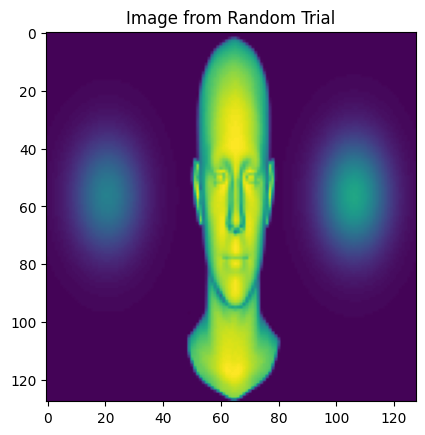

In [ ]:
image= images[10,:,:,0]
plt.title('Image from Random Trial')
plt.imshow(image)#cmap='grey')# this is some random images from the dataset

### Load the label (Change the Directory!!!)

In [ ]:
index=100 ########## change the index for the trial you input###########
mat_file_path = '/content/drive/My Drive/project/label.mat'
mat = sio.loadmat(mat_file_path)
labels = mat['labels'][:, 1][0:index]

### Some image pre-processing

In [ ]:
images=np.float16(images)# save the ram, you can change it back to 64

In [ ]:
images = np.expand_dims(images, axis=-1)  # Add a channel dimension at the last axis

In [ ]:
print(images.shape)
print(labels.shape)

(100, 128, 128, 1, 1)
(100,)


### Do a train-test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42) # change here for the test and training size

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(80, 128, 128, 1, 1) (80,)
(20, 128, 128, 1, 1) (20,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) #check if we are using GPU

Num GPUs Available:  0


### The 3D CNN Model

In [ ]:
def create_model_3dcnn(width=target_height, height=target_width, depth=frame_rate):

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPool3D(pool_size=3)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=256, kernel_size=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="3dcnn_sequential")

    return model

### The TCN Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tcn import TCN

def create_model_tcn(width=target_width, height= target_height, depth=frame_rate):

    inputs = keras.Input((height, width,depth, 1))  # Depth corresponds to time dimension

    x = layers.TimeDistributed(layers.Conv2D(32, kernel_size=(3, 3), padding='same'))(inputs)
    x = layers.TimeDistributed(layers.Activation('relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Dropout(0.25))(x)

    x = layers.TimeDistributed(layers.Flatten())(x)

    x = TCN(nb_filters=64, kernel_size=6, nb_stacks=1, dilations=[1, 2, 4, 8, 16], padding='causal',
            use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='relu',
            kernel_initializer='he_normal', use_batch_norm=False, use_layer_norm=False, use_weight_norm=False)(x)

    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Dropout layer

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name="tcn_model")

    return model


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05) # change optimizer here

In [ ]:
#with tf.device('/cpu:0'): #here uncomment to use cpu
model = create_model_3dcnn()# change here if you want to change model
model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Training

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=2, validation_split=0.1)
!nvidia-smi# code for checking the ram

Epoch 1/100
35/35 [==============================] - 5s 90ms/step - loss: 8.6300 - accuracy: 0.5286 - precision_11: 0.4848 - recall_11: 0.5000 - val_loss: 1580.2996 - val_accuracy: 0.3667 - val_precision_11: 0.3667 - val_recall_11: 1.0000
Epoch 2/100
35/35 [==============================] - 3s 75ms/step - loss: 11.0445 - accuracy: 0.4429 - precision_11: 0.4000 - recall_11: 0.4375 - val_loss: 25.1993 - val_accuracy: 0.3667 - val_precision_11: 0.3667 - val_recall_11: 1.0000
Epoch 3/100
35/35 [==============================] - 3s 75ms/step - loss: 22.8983 - accuracy: 0.5571 - precision_11: 0.5152 - recall_11: 0.5312 - val_loss: 19.8227 - val_accuracy: 0.3667 - val_precision_11: 0.3667 - val_recall_11: 1.0000
Epoch 4/100
35/35 [==============================] - 3s 75ms/step - loss: 7.7764 - accuracy: 0.5000 - precision_11: 0.4516 - recall_11: 0.4375 - val_loss: 9.8939 - val_accuracy: 0.3667 - val_precision_11: 0.3667 - val_recall_11: 1.0000
Epoch 5/100
35/35 [==============================

In [ ]:
  score = model.evaluate(X_test, y_test)
  print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

4/4 [==============================] - 4s 879ms/step - loss: 0.6895 - accuracy: 0.5700 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00
Test loss: 0.6894922852516174 / Test accuracy: 0.5699999928474426


# visualize model here

In [ ]:
from tensorflow.keras.models import Model

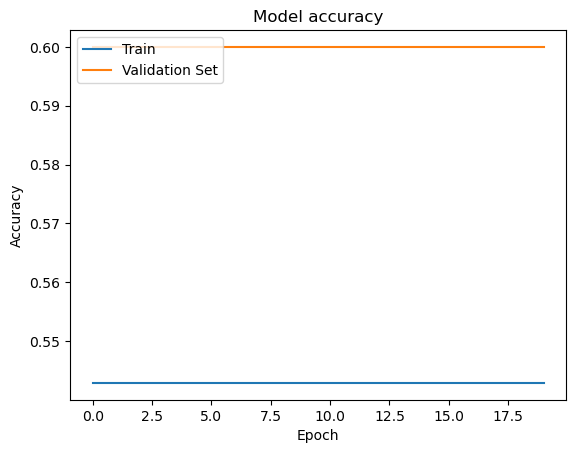

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation Set'], loc='upper left')
plt.show()

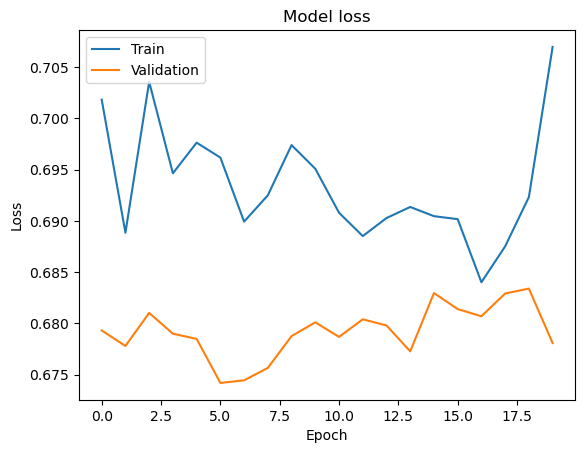

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()